In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install https://github.com/Antonio-Ionaton/GradientCorrection/tarball/main
#!pip uninstall gradientcorrection

In [ ]:
import gradientcorrection
from gradientcorrection import layers, utils, metrics, helper, explain, model_zoo, geomath

#### import python modules

In [ ]:
import os, h5py
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow import keras

#### load data

In [ ]:
experiment ='FOXK2'  # Include list of 10 proteins here. 
filename = experiment + '_200.h5'

data_path = 'drive/My Drive/'
results_path = utils.make_directory('drive/My Drive/', 'results_invivo(real_ensemble)')  #utils.make_directory('../results', 'task3')
params_path = utils.make_directory(results_path, 'model_params') 

file_path = os.path.join(data_path, filename)
dataset = h5py.File(file_path, 'r') 
x_train = np.array(dataset['x_train']).astype(np.float32).transpose([0,2,1])  
y_train = np.array(dataset['y_train']).astype(np.float32)
x_valid = np.array(dataset['x_valid']).astype(np.float32).transpose([0,2,1])
y_valid = np.array(dataset['y_valid']).astype(np.float32)
x_test = np.array(dataset['x_test']).astype(np.float32).transpose([0,2,1])
y_test = np.array(dataset['y_test']).astype(np.float32)
print(dataset.keys())  
print(x_train.shape)
print(x_test.shape)

<KeysViewHDF5 ['x_test', 'x_train', 'x_valid', 'y_test', 'y_train', 'y_valid']>
(2196, 200, 4)


In [ ]:
################################################################################# TRAINING


import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
from tensorflow import keras
#from tfomics import utils, metrics


num_trials = 10  #num_trials = 10
model_names = ['cnn-dist', 'cnn-local'] #model_names = ['cnn-dist', 'cnn-local']
activations = ['relu', 'exponential'] 

results_path = utils.make_directory('drive/My Drive/results_invivo(real_ensemble)', 'task3')  #utils.make_directory('../results', 'task3')
params_path = utils.make_directory(results_path, 'model_params')  #utils.make_directory(results_path, 'model_params')

#Ensemble version - varied filter size
###################################################################################
kernel_size=[3, 5, 7, 9,11,13,15,17,19,21]
'''
with open(os.path.join(results_path, 'task3_classification_performance.tsv'), 'w') as f:
    f.write('%s\t%s\t%s\n'%('model', 'ave roc', 'ave pr'))

    results = {}
    for model_name in model_names:
        for activation in activations:
            base_name = model_name+'_'+activation
            print(base_name)
            results[base_name] = {}
            
            trial_roc_mean = []
            trial_roc_std = []
            trial_pr_mean = []
            trial_pr_std = []
            for trial in range(num_trials):
                keras.backend.clear_session()
                
                # load model
                model = helper.load_model(model_name, first_layer_kernel_size=kernel_size[trial], activation=activation)  # Note: load_model function was changed to receive first_layer_kernel_size. May not work without it.
                name = base_name+'_'+str(trial)
                print('model: ' + name)

                # compile model
                helper.compile_model(model)  #helper.compile_model(model)

                # setup callbacks
                callbacks = helper.get_callbacks(monitor='val_auroc', patience=20,   #callbacks = helper.get_callbacks(monitor='val_auroc', patience=20,
                                          decay_patience=5, decay_factor=0.2)   #it was 5

                # fit model
                history = model.fit(x_train, y_train, 
                                    epochs=100,
                                    batch_size=100, 
                                    shuffle=True,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=callbacks)

                # save model
                weights_path = os.path.join(params_path, base_name+'_'+ experiment + '_'+ str(trial)+'.hdf5')
                model.save_weights(weights_path)

                # predict test sequences and calculate performance metrics
                predictions = model.predict(x_test)                
                mean_vals, std_vals = metrics.calculate_metrics(y_test, predictions, 'binary')

                trial_roc_mean.append(mean_vals[1])
                trial_roc_std.append(std_vals[1])
                trial_pr_mean.append(mean_vals[2])
                trial_pr_std.append(std_vals[2])


            results[base_name] = [np.array(trial_roc_mean), np.array(trial_pr_mean)]
            f.write("%s\t%.3f+/-%.3f\t%.3f+/-%.3f\n"%(base_name, 
                                                      np.mean(trial_roc_mean),
                                                      np.std(trial_roc_mean), 
                                                      np.mean(trial_pr_mean),
                                                      np.std(trial_pr_mean)))

# save results
file_path = os.path.join(results_path, 'task3_performance_results.pickle')
with open(file_path, 'wb') as f:
    cPickle.dump(results, f, protocol=cPickle.HIGHEST_PROTOCOL)
'''



In [ ]:
print(activation)

exponential


In [ ]:
# Load model weights to evaluate all models 
num_trials = 10 
model_names = ['cnn-dist'] #model_names = ['cnn-dist', 'cnn-local']
activations = ['relu']

for trial in range(num_trials):

    for model_name in model_names: 
        for activation in activations: 

            model_name = model_name +'_'+activation + '_' + experiment +'_'+ str(trial) + '.hdf5'

            model_path = os.path.join(params_path, model_name)
            model.load_weights(model_path)
            results = model.evaluate(x_test, y_test, batch_size=128)
            print(model_name, 'test loss, test results:', results)

In [ ]:
!pip install logomaker

     |████████████████████████████████| 11.8 MB 7.0 MB/s 


In [ ]:
import pandas as pd
import logomaker
import matplotlib.pyplot as plt

#### calculate attribution scores

In [ ]:
data_path = 'drive/My Drive/'
results_path = utils.make_directory('drive/My Drive/', 'results_invivo(real_ensemble)/task3')  #utils.make_directory('../results', 'task3')
params_path = utils.make_directory(results_path, 'model_params') 

num_plots = 1000
class_index = 0

# get high predicted sequences 
pos_index = np.where(y_test[:, class_index] == 1)[0]
#predictions = model.predict(x_test[pos_index])
plot_index = pos_index #[np.argsort(predictions[:,class_index])[::-1]]
#X = x_test[plot_index[0:num_plots]]
X = x_test[plot_index[:]]

attr_score1_cumulative = []
attr_score2_cumulative = []
saliency_map_raw_cummulative = []


attr_score1_take = []
attr_score2_take = []

# Loop and load model weights
num_trials = 10  #50
model_names = ['cnn-dist'] #model_names = ['cnn-dist', 'cnn-local']
activations = ['exponential']  #['relu', 'exponential']

kernel_size=[3, 5, 7, 9,11,13,15,17,19,21]

for trial in range(num_trials):
    for model_name in model_names:
        for activation in activations:    

            keras.backend.clear_session()
            
            # load model
            model = helper.load_model( model_name, first_layer_kernel_size=kernel_size[trial], activation=activation)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            # compile model
            helper.compile_model(model)

            # load model

            model_name = model_name +'_'+activation + '_' + experiment +'_'+ str(trial) + '.hdf5'
            print('Calculating attributions for ', model_name)
            model_path = os.path.join(params_path, model_name)
            model.load_weights(model_path)

            saliency_map_raw =  np.array(explain.saliency(model, X, class_index=0, layer=-2, batch_size=256))

            attr_score1 = saliency_map_raw #* X
            attr_score2 = attr_score1 - 0.25 * np.sum(saliency_map_raw , axis=2, keepdims=True)

            attr_score1_cumulative.append(attr_score1)
            attr_score2_cumulative.append(attr_score2)
            saliency_map_raw_cummulative.append(saliency_map_raw)

            if (trial==9): 
                attr_score1_take = attr_score1
                attr_score2_take = attr_score2


model: cnn-dist_exponential_0
Calculating attributions for  cnn-dist_exponential_FOXK2_0.hdf5
model: cnn-dist_exponential_1
Calculating attributions for  cnn-dist_exponential_FOXK2_1.hdf5
model: cnn-dist_exponential_2
Calculating attributions for  cnn-dist_exponential_FOXK2_2.hdf5
model: cnn-dist_exponential_3
Calculating attributions for  cnn-dist_exponential_FOXK2_3.hdf5
model: cnn-dist_exponential_4
Calculating attributions for  cnn-dist_exponential_FOXK2_4.hdf5
model: cnn-dist_exponential_5
Calculating attributions for  cnn-dist_exponential_FOXK2_5.hdf5
model: cnn-dist_exponential_6
Calculating attributions for  cnn-dist_exponential_FOXK2_6.hdf5
model: cnn-dist_exponential_7
Calculating attributions for  cnn-dist_exponential_FOXK2_7.hdf5
model: cnn-dist_exponential_8
Calculating attributions for  cnn-dist_exponential_FOXK2_8.hdf5
model: cnn-dist_exponential_9
Calculating attributions for  cnn-dist_exponential_FOXK2_9.hdf5


In [ ]:

attr_score1_AVERAGE = np.average(np.array(attr_score1_cumulative)  , axis = 0)
attr_score2_AVERAGE = np.average(np.array(attr_score2_cumulative)  , axis = 0)
saliency_map_raw_AVERAGE = np.average(np.array(saliency_map_raw_cummulative)  , axis = 0)
saliency_map_raw_AVERAGE_CORRECTED = saliency_map_raw_AVERAGE - 0.25* np.sum(saliency_map_raw_AVERAGE, axis=2, keepdims=True)


(1097, 200, 4)


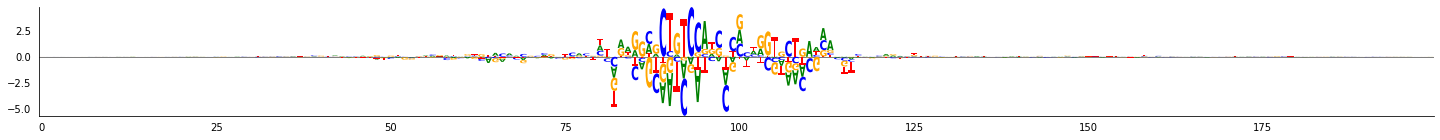

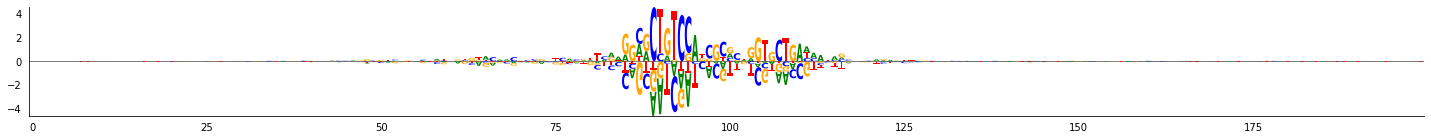

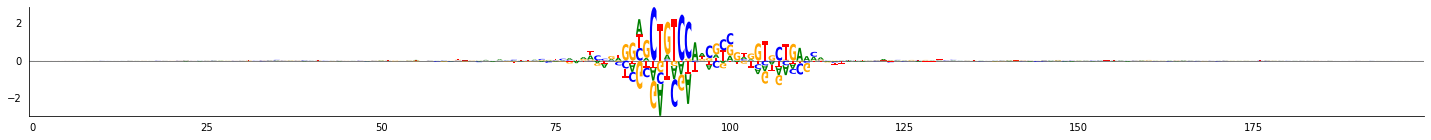

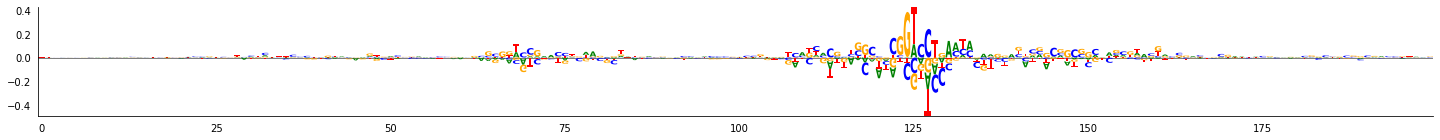

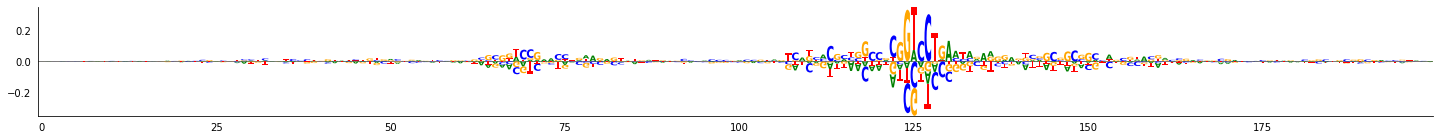

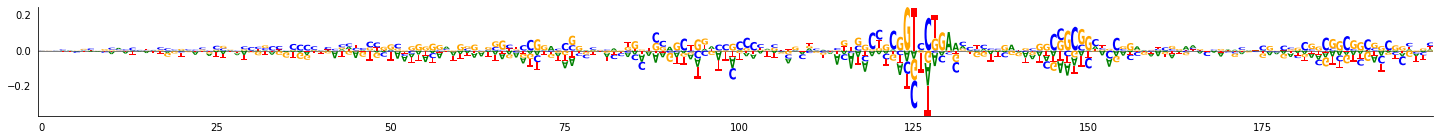

In [ ]:

p=28
N, L, A = attr_score1.shape
for i in range(p,p+1):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score1_take[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    fig = plt.gcf()
    

N, L, A = attr_score1.shape
for i in range(p,p+1):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score2_take[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    fig = plt.gcf()

   
N, L, A = attr_score1.shape
for i in range(p,p+1):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = saliency_map_raw_AVERAGE[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    fig = plt.gcf()

###########################

p=29
N, L, A = attr_score1.shape
for i in range(p,p+1):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score1_take[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    fig = plt.gcf()
    
N, L, A = attr_score1.shape
for i in range(p,p+1):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score2_take[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    fig = plt.gcf()
 
N, L, A = attr_score1.shape
for i in range(p,p+1):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = saliency_map_raw_AVERAGE[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    fig = plt.gcf()


# Calculate saliency map and angles

In [ ]:

sine = geomath.calculate_angles(saliency_map_raw_cummulative) 
L2_=geomath.L2(saliency_map_raw_cummulative)
dispersion_ = geomath.dispersion(saliency_map_raw_cummulative, saliency_map_raw_AVERAGE) 

sine_enbemble = geomath.calculate_angles(saliency_map_raw_AVERAGE) 

saliency_map_raw_cummulative_corrected = saliency_map_raw_cummulative - 0.25 * np.sum(saliency_map_raw_cummulative , axis=-1, keepdims=True)
dispersion_after_correction = geomath.dispersion(saliency_map_raw_cummulative_corrected, saliency_map_raw_AVERAGE) 
sine_corrected =  geomath.calculate_angles(saliency_map_raw_cummulative_corrected)  
L2_corrected=  geomath.L2(saliency_map_raw_cummulative_corrected)  


In [ ]:
print(np.average(dispersion_))
print(np.average(dispersion_after_correction))

0.14351618
0.13100183


In [ ]:
sine_flat = sine.reshape(-1)
sine_no_nan = sine_flat [np.logical_not( np.isnan(sine_flat))]
print(np.std(sine_no_nan))


26.646551


"plt.figure(figsize=(10,2))\nplt.hist(np.reshape(sine_corrected,[-1]), 100, density=True, alpha=0.5, color='g')\nplt.ylabel('Density', fontsize=25)\nplt.xticks([-90, -60, -30, 0, 30, 60, 90], fontsize=22)\n#plt.tick_params(axis='x',  which='both', bottom=False,  top=False, labelbottom=False) \nplt.yticks(ticks=[0.0, 0.01, 0.02], fontsize=20)\n#plt.xlim([-85, 85])"

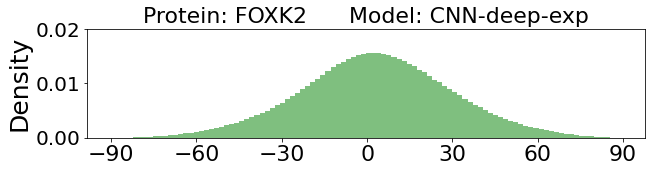

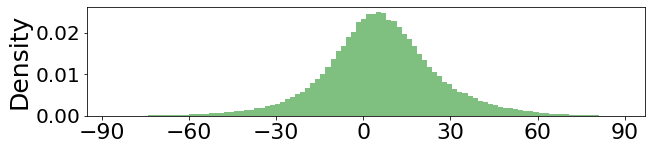

In [ ]:
plt.figure(figsize=(10,2))
plt.hist(np.reshape(sine,[-1]), 100, density=True, alpha=0.5, color='g')
plt.ylabel('Density', fontsize=25)
plt.xticks([-90, -60, -30, 0, 30, 60, 90], fontsize=22)
#plt.tick_params(axis='x',  which='both', bottom=False,  top=False, labelbottom=False) 
plt.yticks(ticks=[0.0, 0.01, 0.02], fontsize=20)
#plt.xlim([-85, 85])
plt.title("Protein: FOXK2      Model: CNN-deep-exp", fontsize=22)

plt.figure(figsize=(10,2))
plt.hist(np.reshape(sine_enbemble,[-1]), 100, density=True, alpha=0.5, color='g')
plt.ylabel('Density', fontsize=25)
plt.xticks([-90, -60, -30, 0, 30, 60, 90], fontsize=22)
#plt.tick_params(axis='x',  which='both', bottom=False,  top=False, labelbottom=False) 
plt.yticks(ticks=[0.0, 0.01, 0.02], fontsize=20)
#plt.xlim([-85, 85])


In [ ]:
#Working on 10 runs - use the np.nan_to_num version 

#Fully flat (1D)
sine_flat = sine.reshape(-1)
L2_flat = L2_.reshape(-1)
dispersion_flat = dispersion_.reshape(-1) 

sine_bins = np.arange(-90,90,5).astype(float)
dispersion_bins_sum =  (sine_bins * 0).astype(float)
dispersion_bins_count = (sine_bins * 0).astype(float)
print (sine_bins)
print(dispersion_flat[0:100])
print(np.average(dispersion_flat))
for i in range (0, len(sine_flat)):
    bin = ((sine_flat[i]+90)/180 * len(sine_bins)).astype(int)
    if(not np.isnan(sine_flat[i]) ): # removing problematic resuls from NA and similar. 
        dispersion_bins_sum[bin]+=dispersion_flat[i] 
        dispersion_bins_count[bin]+=1

dispersion_bins = dispersion_bins_sum / dispersion_bins_count
print(dispersion_bins_count)



#Corrected version
sine_flat = sine.reshape(-1)
L2__corrected_flat = L2_corrected.reshape(-1)
dispersion_flat = dispersion_after_correction.reshape(-1) 

sine_bins = np.arange(-90,90,5).astype(float)
dispersion_bins_sum =  (sine_bins * 0).astype(float)
dispersion_bins_count = (sine_bins * 0).astype(float)
print (sine_bins)
for i in range (0, len(sine_flat)):
    bin = ((sine_flat[i]+90)/180 * len(sine_bins)).astype(int)
    if(not np.isnan(sine_flat[i]) ): # removing problematic resuls from NA and similar.  
        dispersion_bins_sum[bin]+=dispersion_flat[i] 
        dispersion_bins_count[bin]+=1

dispersion_bins_corrected = dispersion_bins_sum / dispersion_bins_count



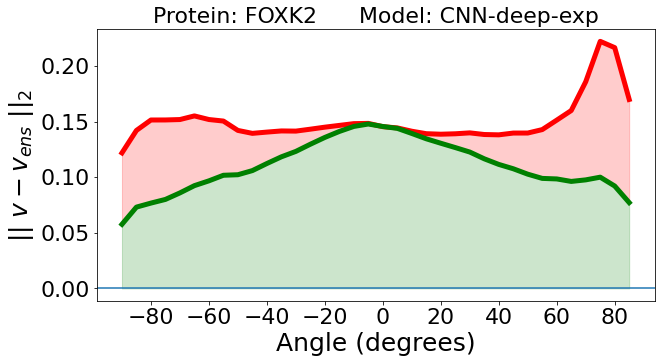

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(sine_bins, dispersion_bins, '-', color='red',linewidth=5.0)
plt.fill_between(sine_bins, dispersion_bins, dispersion_bins_corrected, color="red", alpha=0.2)
plt.xlabel('Angle (degrees)', fontsize=25)
plt.ylabel('|| $v - v_{ens}$ ||$_{2}$', fontsize=25)
plt.xticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], fontsize=22)
plt.yticks( fontsize=22)
plt.axhline(0)
#plt.axvline(0)

plt.plot(sine_bins, dispersion_bins_corrected, '-', color='green', linewidth=5.0)
plt.fill_between(sine_bins, dispersion_bins_corrected, 0, color="green", alpha=0.2)

plt.title("Protein: FOXK2      Model: CNN-deep-exp", fontsize=22)

plt.show()

In [ ]:
#### COUNT LARGE ANGLES

#count large angles
large_angle = 30
count_large_angles30 = np.zeros((len(sine),len(sine[0])))
for z in range (len(sine)):
    for i in range (len(sine[0])):
        count=0
        for j in range (len(sine[0,0])):
            if(np.abs(sine[z,i,j])>large_angle): count+=1  
        count_large_angles30[z,i]=count
count_large_angles30=np.array(count_large_angles30.reshape(len(count_large_angles30)*len(count_large_angles30[0]),))  
count_large_angles30=100* count_large_angles30/len(sine[0,0])

#count large angles
large_angle = 45
count_large_angles45 = np.zeros((len(sine),len(sine[0])))
for z in range (len(sine)):
    for i in range (len(sine[0])):
        count=0
        for j in range (len(sine[0,0])):
            if(np.abs(sine[z,i,j])>large_angle): count+=1  
        count_large_angles45[z,i]=count
count_large_angles45=np.array(count_large_angles45.reshape(len(count_large_angles45)*len(count_large_angles45[0]),))  
count_large_angles45=100* count_large_angles45/len(sine[0,0])

#count large angles
large_angle = 60
count_large_angles60 = np.zeros((len(sine),len(sine[0])))
for z in range (len(sine)):
    for i in range (len(sine[0])):
        count=0
        for j in range (len(sine[0,0])):
            if(np.abs(sine[z,i,j])>large_angle): count+=1  
        count_large_angles60[z,i]=count
count_large_angles60=np.array(count_large_angles60.reshape(len(count_large_angles60)*len(count_large_angles60[0]),))  
count_large_angles60=100* count_large_angles60/len(sine[0,0])

In [ ]:
print(np.average(count_large_angles30))
print(np.average(count_large_angles45))
print(np.average(count_large_angles60))

20.540880989180835
7.472282328696548
2.115507470376095


(-2.0, 50.0)

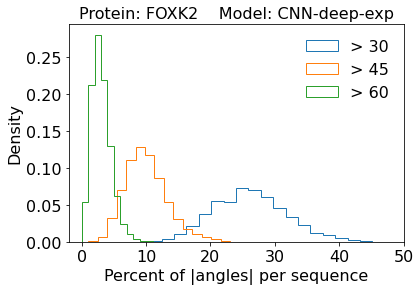

In [ ]:
#plt.figure(figsize=(10,2))
plt.hist(count_large_angles30,20,  histtype='step', stacked=True, fill=False, label = '> 30', density=True)
plt.hist(count_large_angles45,18,  histtype='step', stacked=True, fill=False, label = '> 45', density=True)
plt.hist(count_large_angles60,14,  histtype='step', stacked=True, fill=False, label = '> 60', density=True)

plt.ylabel('Density', fontsize=16)
plt.xlabel('Percent of |angles| per sequence', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([0, 0.05, 0.10, 0.15, 0.20, 0.25], fontsize=16)
#plt.yticks([0.1, 0.2, 0.3, 0.4], fontsize=16)
plt.legend(loc='upper right', fontsize=16, frameon=False);
plt.title("Protein: FOXK2    Model: CNN-deep-exp", fontsize=16, loc='center', pad=None)
plt.xlim(-2,50)

In [ ]:
##### Chip-Seq , CNN-shallow-relu
angle_STD_1 = np.array ( [22.624, 28.347, 30.982, 27.106, 23.365, 30.215, 26.948, 30.845, 27.187, 31.384] )

##### Chip-Seq , CNN-shallow-exp
angle_STD_2 = np.array( [23.524, 29.453, 30.222, 25.88, 24.098, 30.157, 26.95, 31.413, 27.251, 31.342])

##### Chip-Seq , CNN-deep-relu
angle_STD_3 = np.array( [19.437, 22.622, 27.105, 23.342, 19.421, 26.463, 22.91, 26.723, 24.095, 27.015])

##### Chip-Seq , CNN-deep-exp
angle_STD_4 = np.array ([20.579, 25.03, 26.646, 22.849, 21.895, 26.336, 23.526, 26.808, 24.297, 28.307])

##### RNACompete
angle_STD_rna = np.array([23.895, 23.329, 21.169, 23.91, 23.272, 21.622, 22.909, 24.034, 23.148, 22.152])

##### Synthetic
angle_STD_syn = np.array([24.025,	29.341,	26.62,	30.083])

data = np.array ([angle_STD_1, angle_STD_2, angle_STD_3, angle_STD_4, angle_STD_rna])

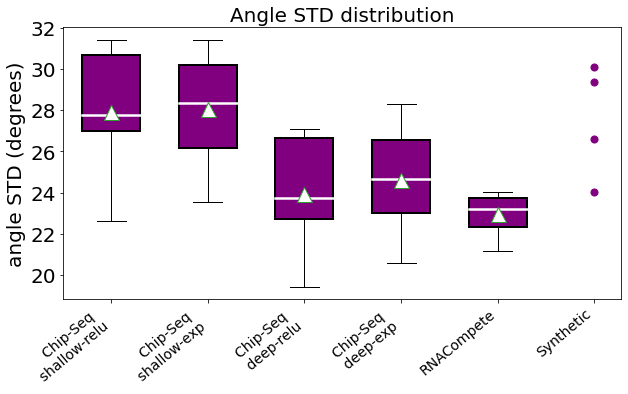

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

figure_title = "Angle STD distribution"

fig = plt.figure(figsize=(10,5))
flierprops = dict(marker='^', markerfacecolor='white', markersize=15, linestyle='none')  
medianprops = dict(color="white",linewidth=2.5)
box = plt.boxplot(data.T, showfliers=True, showmeans=True, meanprops=flierprops, patch_artist=True, medianprops=medianprops, widths = 0.6);
plt.xticks([1, 2, 3, 4, 5, 6, 7], [ 'Chip-Seq \n shallow-relu', 'Chip-Seq \n shallow-exp',  'Chip-Seq \n deep-relu', 'Chip-Seq \n deep-exp', 'RNACompete',  'Synthetic'], rotation=40, fontsize=14, ha='right');  #  ''
ax = plt.gca();
#ax.set_ylim(-3,6) 
ax.set_title(figure_title, fontsize=20) 
plt.setp(ax.get_yticklabels(),fontsize=20);
plt.ylabel('angle STD (degrees)', fontsize=20)

for box in box['boxes']:
    # change outline color
    box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'purple' )
    # change hatch
    #box.set(hatch = '.')

#Scatter for the few points of the synthetic 
plt.scatter( np.array([6,6,6,6]), angle_STD_syn, s=50, edgecolors='purple',facecolors='purple', marker="o", alpha=1)


plt.show()

In [ ]:
##### Chip-Seq , CNN-shallow-relu
angle_30_1 = np.array ( [16.702, 28.418, 33.263, 25.218, 17.494, 31.841, 25.448, 33.38, 25.403, 34.047] )

##### Chip-Seq , CNN-shallow-exp
angle_30_2 = np.array( [18.672, 29.661, 31.416, 22.984, 18.354, 31.409, 24.939, 33.779, 25.233, 34.78])

##### Chip-Seq , CNN-deep-relu
angle_30_3 = np.array( [11.902, 17.682, 27.42, 19.918, 11.778, 25.546, 18.442, 26.285, 20.314, 26.787])

##### Chip-Seq , CNN-deep-exp
angle_30_4 = np.array ([13.71, 21.959, 26.201, 17.862, 15.463, 24.785, 19.158, 26.238, 20.541, 29.47])

##### RNAcompete
angle_30_rna = np.array ([22.474, 19.158, 14.92, 19.543, 19.531, 16.223, 17.901, 20.805, 18.41, 16.581])

##### Synthetic
angle_30_syn = np.array([20.123,	27.455,	25.348,	30.398])

data = np.array ([angle_30_1, angle_30_2, angle_30_3, angle_30_4, angle_30_rna])

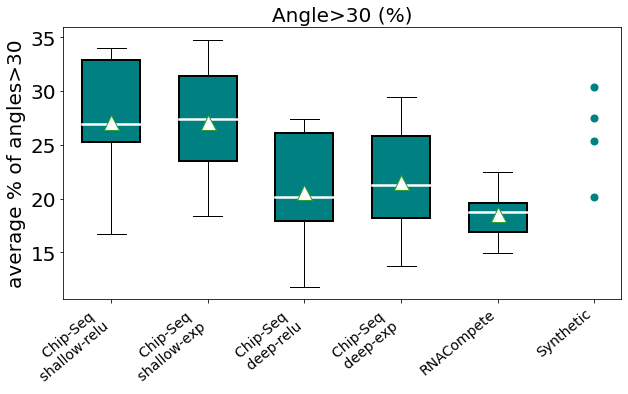

In [ ]:
figure_title = "Angle>30 (%)"

fig = plt.figure(figsize=(10,5))
flierprops = dict(marker='^', markerfacecolor='white', markersize=15, linestyle='none')  
medianprops = dict(color="white",linewidth=2.5)
box = plt.boxplot(data.T, showfliers=True, showmeans=True, meanprops=flierprops, patch_artist=True, medianprops=medianprops, widths = 0.6);
plt.xticks([1, 2, 3, 4, 5, 6, 7], [ 'Chip-Seq \n shallow-relu', 'Chip-Seq \n shallow-exp',  'Chip-Seq \n deep-relu', 'Chip-Seq \n deep-exp', 'RNACompete',  'Synthetic'], rotation=40, fontsize=14, ha='right');  #  ''
ax = plt.gca();
#ax.set_ylim(-3,6) 
ax.set_title(figure_title, fontsize=20) 
plt.setp(ax.get_yticklabels(),fontsize=20);
plt.ylabel('average % of angles>30', fontsize=20)

for box in box['boxes']:
    # change outline color
    box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'teal' )
    # change hatch
    #box.set(hatch = '.')

#Scatter for the few points of the synthetic 
plt.scatter( np.array([6,6,6,6]), angle_30_syn, s=50, edgecolors='teal',facecolors='teal', marker="o", alpha=1)

plt.show()

In [ ]:
##### Chip-Seq , CNN-shallow-relu
angle_45_1 = np.array ( [5.219, 11.362, 14.963, 10.074, 6.211, 13.873, 9.922, 15.05, 10.021, 15.614] )

##### Chip-Seq , CNN-shallow-exp
angle_45_2 = np.array( [6.01, 12.986, 13.997, 8.423, 6.985, 13.679, 9.739, 15.754, 10.101, 15.588])

##### Chip-Seq , CNN-deep-relu
angle_45_3 = np.array( [3.397, 5.7, 10.447, 6.627, 3.342, 9.526, 5.864, 9.779, 7.331, 10.177])

##### Chip-Seq , CNN-deep-exp
angle_45_4 = np.array ([4.19, 8.173, 9.962, 6.096, 5.515, 9.551, 6.446, 10.061, 7.472, 12.258])

##### RNAcompete
angle_45_rna = np.array ([7.891, 6.101, 4.209, 6.376, 6.885, 5.303, 5.783, 7.032, 5.839, 5.048])

##### Synthetic
angle_45_syn = np.array([7.341,	14.02,	10.127,	15.066])

data = np.array ([angle_45_1, angle_45_2, angle_45_3, angle_45_4, angle_45_rna])

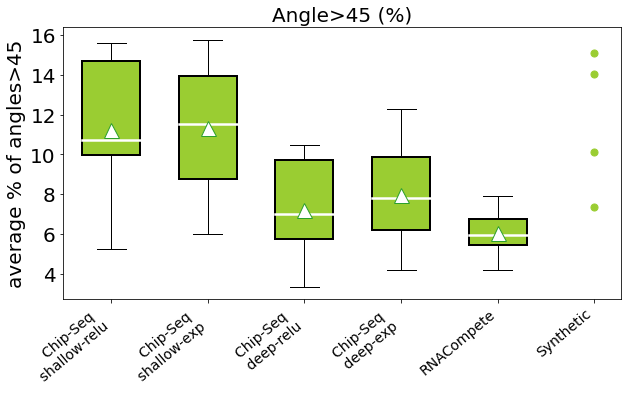

In [ ]:
figure_title = "Angle>45 (%)"

fig = plt.figure(figsize=(10,5))
flierprops = dict(marker='^', markerfacecolor='white', markersize=15, linestyle='none')  
medianprops = dict(color="white",linewidth=2.5)
box = plt.boxplot(data.T, showfliers=True, showmeans=True, meanprops=flierprops, patch_artist=True, medianprops=medianprops, widths = 0.6);
plt.xticks([1, 2, 3, 4, 5, 6, 7], [ 'Chip-Seq \n shallow-relu', 'Chip-Seq \n shallow-exp',  'Chip-Seq \n deep-relu', 'Chip-Seq \n deep-exp', 'RNACompete',  'Synthetic'], rotation=40, fontsize=14, ha='right');  #  ''
ax = plt.gca();
#ax.set_ylim(-3,6) 
ax.set_title(figure_title, fontsize=20) 
plt.setp(ax.get_yticklabels(),fontsize=20);
plt.ylabel('average % of angles>45', fontsize=20)

for box in box['boxes']:
    # change outline color
    box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'yellowgreen' )
    # change hatch
    #box.set(hatch = '.')

#Scatter for the few points of the synthetic 
plt.scatter( np.array([6,6,6,6]), angle_45_syn, s=50, edgecolors='yellowgreen',facecolors='yellowgreen', marker="o", alpha=1)

plt.show()

In [ ]:
##### Chip-Seq , CNN-shallow-relu
angle_60_1 = np.array ( [1.237, 3.094, 4.799, 2.914, 1.75, 4.289, 2.634, 4.761, 2.857, 5.151] )

##### Chip-Seq , CNN-shallow-exp
angle_60_2 = np.array( [1.589, 4.208, 4.488, 2.353, 2.303, 4.346, 2.856, 5.481, 3.153, 4.921])

##### Chip-Seq , CNN-deep-relu
angle_60_3 = np.array( [0.771, 1.394, 2.818, 1.646, 0.767, 2.565, 1.409, 2.588, 1.997, 2.763])

##### Chip-Seq , CNN-deep-exp
angle_60_4 = np.array ([1.018, 2.398, 2.789, 1.606, 1.653, 2.841, 1.727, 2.853, 2.115, 3.714])

##### RNAcompete
angle_60_rna = np.array ([2.266, 1.65, 0.95, 1.82, 1.963, 1.492, 1.469, 1.921, 1.49, 1.206])

##### Synthetic
angle_60_syn = np.array([2.019,	6.267,	3.045,	6.109])

data = np.array ([angle_60_1, angle_60_2, angle_60_3, angle_60_4, angle_60_rna])

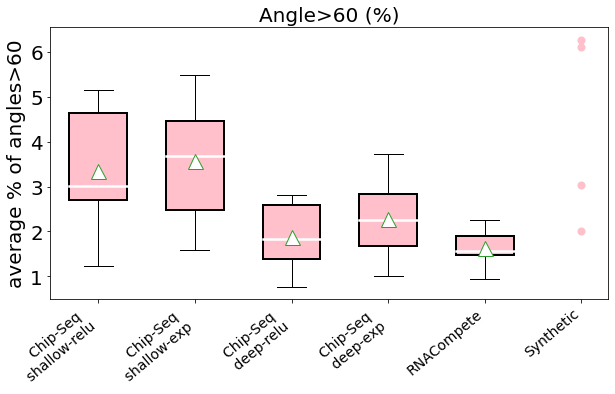

In [ ]:
figure_title = "Angle>60 (%)"

fig = plt.figure(figsize=(10,5))
flierprops = dict(marker='^', markerfacecolor='white', markersize=15, linestyle='none')  
medianprops = dict(color="white",linewidth=2.5)
box = plt.boxplot(data.T, showfliers=True, showmeans=True, meanprops=flierprops, patch_artist=True, medianprops=medianprops, widths = 0.6);
plt.xticks([1, 2, 3, 4, 5, 6, 7], [ 'Chip-Seq \n shallow-relu', 'Chip-Seq \n shallow-exp',  'Chip-Seq \n deep-relu', 'Chip-Seq \n deep-exp', 'RNACompete',  'Synthetic'], rotation=40, fontsize=14, ha='right');  #  ''
ax = plt.gca();
#ax.set_ylim(-3,6) 
ax.set_title(figure_title, fontsize=20)
plt.setp(ax.get_yticklabels(),fontsize=20);
plt.ylabel('average % of angles>60', fontsize=20)

for box in box['boxes']:
    # change outline color
    box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'pink' )
    # change hatch
    #box.set(hatch = '.')

#Scatter for the few points of the synthetic 
plt.scatter( np.array([6,6,6,6]), angle_60_syn, s=50, edgecolors='pink',facecolors='pink', marker="o", alpha=1)

plt.show()

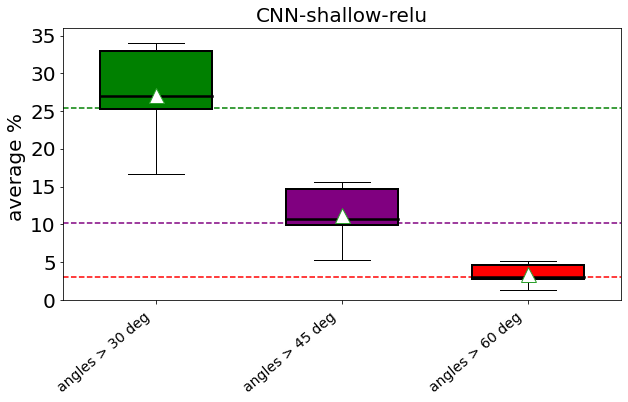

In [ ]:
##### CNN-shallow-relu

data = np.array ([angle_30_1, angle_45_1, angle_60_1])



figure_title = "CNN-shallow-relu"

fig = plt.figure(figsize=(10,5))
flierprops = dict(marker='^', markerfacecolor='white', markersize=15, linestyle='none')  
medianprops = dict(color="black",linewidth=2.5)

box = plt.boxplot(data[0].T, positions=[0], showfliers=True, showmeans=True, meanprops=flierprops, medianprops=medianprops , patch_artist=True,  widths = 0.6);  # medianprops=medianprops  , showmeans=True
for box in box['boxes']:
    box.set(color='black', linewidth=2)
    box.set(facecolor = 'green' )

box = plt.boxplot(data[1].T, positions=[1], showfliers=True, showmeans=True, meanprops=flierprops, medianprops=medianprops , patch_artist=True,  widths = 0.6);  # medianprops=medianprops  , showmeans=True
for box in box['boxes']:
    box.set(color='black', linewidth=2)
    box.set(facecolor = 'purple' )

box = plt.boxplot(data[2].T, positions=[2], showfliers=True, showmeans=True, meanprops=flierprops, medianprops=medianprops , patch_artist=True,  widths = 0.6);  # medianprops=medianprops  , showmeans=True
for box in box['boxes']:
    box.set(color='black', linewidth=2)
    box.set(facecolor = 'red' )


plt.xticks([0, 1, 2], [ 'angles > 30 deg ', 'angles > 45 deg ',  'angles > 60 deg '], rotation=40, fontsize=14, ha='right');  #  ''
ax = plt.gca();
ax.set_ylim(0,36) 
ax.set_title(figure_title, fontsize=20) 
plt.setp(ax.get_yticklabels(),fontsize=20);
plt.ylabel('average % ', fontsize=20)

plt.axhline(y=25.348, color='green', linestyle='--')
plt.axhline(y=10.127, color='purple', linestyle='--')
plt.axhline(y=3.045, color='red', linestyle='--')

plt.show()

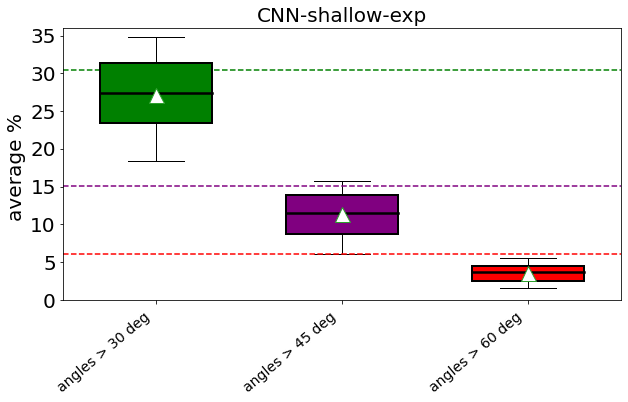

In [ ]:
##### CNN-shallow-exp

data = np.array ([angle_30_2, angle_45_2, angle_60_2])



figure_title = "CNN-shallow-exp"

fig = plt.figure(figsize=(10,5))
flierprops = dict(marker='^', markerfacecolor='white', markersize=15, linestyle='none')  
medianprops = dict(color="black",linewidth=2.5)

box = plt.boxplot(data[0].T, positions=[0], showfliers=True, showmeans=True, meanprops=flierprops, medianprops=medianprops , patch_artist=True,  widths = 0.6);  # medianprops=medianprops  , showmeans=True
for box in box['boxes']:
    box.set(color='black', linewidth=2)
    box.set(facecolor = 'green' )

box = plt.boxplot(data[1].T, positions=[1], showfliers=True, showmeans=True, meanprops=flierprops, medianprops=medianprops , patch_artist=True,  widths = 0.6);  # medianprops=medianprops  , showmeans=True
for box in box['boxes']:
    box.set(color='black', linewidth=2)
    box.set(facecolor = 'purple' )

box = plt.boxplot(data[2].T, positions=[2], showfliers=True, showmeans=True, meanprops=flierprops, medianprops=medianprops , patch_artist=True,  widths = 0.6);  # medianprops=medianprops  , showmeans=True
for box in box['boxes']:
    box.set(color='black', linewidth=2)
    box.set(facecolor = 'red' )


plt.xticks([0, 1, 2], [ 'angles > 30 deg ', 'angles > 45 deg ',  'angles > 60 deg '], rotation=40, fontsize=14, ha='right');  #  ''
ax = plt.gca();
ax.set_ylim(0,36) 
ax.set_title(figure_title, fontsize=20) 
plt.setp(ax.get_yticklabels(),fontsize=20);
plt.ylabel('average % ', fontsize=20)

plt.axhline(y=30.398, color='green', linestyle='--')
plt.axhline(y=15.066, color='purple', linestyle='--')
plt.axhline(y=6.109, color='red', linestyle='--')

plt.show()

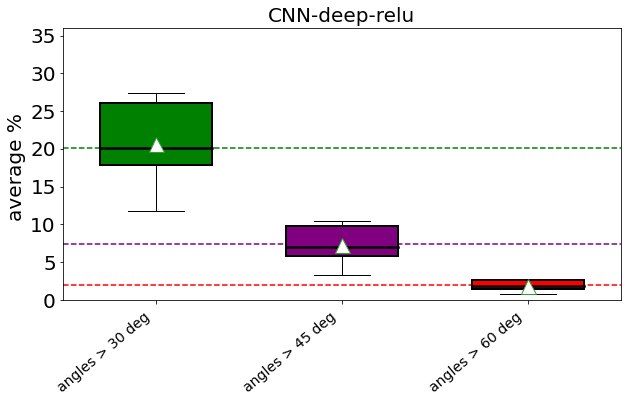

In [ ]:
##### CNN-deep-relu

data = np.array ([angle_30_3, angle_45_3, angle_60_3])



figure_title = "CNN-deep-relu"

fig = plt.figure(figsize=(10,5))
flierprops = dict(marker='^', markerfacecolor='white', markersize=15, linestyle='none')  
medianprops = dict(color="black",linewidth=2.5)

box = plt.boxplot(data[0].T, positions=[0], showfliers=True, showmeans=True, meanprops=flierprops, medianprops=medianprops , patch_artist=True,  widths = 0.6);  # medianprops=medianprops  , showmeans=True
for box in box['boxes']:
    box.set(color='black', linewidth=2)
    box.set(facecolor = 'green' )

box = plt.boxplot(data[1].T, positions=[1], showfliers=True, showmeans=True, meanprops=flierprops, medianprops=medianprops , patch_artist=True,  widths = 0.6);  # medianprops=medianprops  , showmeans=True
for box in box['boxes']:
    box.set(color='black', linewidth=2)
    box.set(facecolor = 'purple' )

box = plt.boxplot(data[2].T, positions=[2], showfliers=True, showmeans=True, meanprops=flierprops, medianprops=medianprops , patch_artist=True,  widths = 0.6);  # medianprops=medianprops  , showmeans=True
for box in box['boxes']:
    box.set(color='black', linewidth=2)
    box.set(facecolor = 'red' )


plt.xticks([0, 1, 2], [ 'angles > 30 deg ', 'angles > 45 deg ',  'angles > 60 deg '], rotation=40, fontsize=14, ha='right');  #  ''
ax = plt.gca();
ax.set_ylim(0,36) 
ax.set_title(figure_title, fontsize=20) 
plt.setp(ax.get_yticklabels(),fontsize=20);
plt.ylabel('average % ', fontsize=20)

plt.axhline(y=20.123, color='green', linestyle='--')
plt.axhline(y=7.341, color='purple', linestyle='--')
plt.axhline(y=2.019, color='red', linestyle='--')

plt.show()

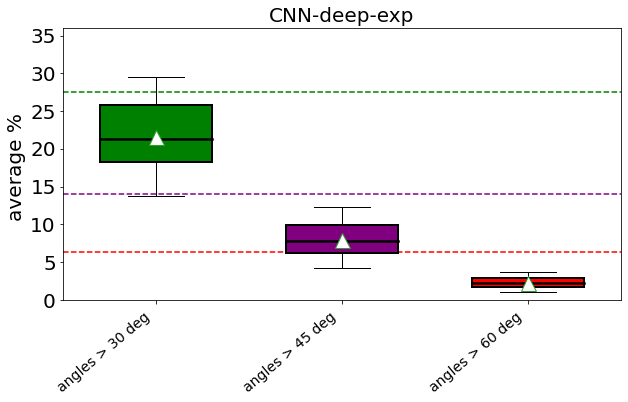

In [ ]:
##### CNN-deep-exp

data = np.array ([angle_30_4, angle_45_4, angle_60_4])



figure_title = "CNN-deep-exp"

fig = plt.figure(figsize=(10,5))
flierprops = dict(marker='^', markerfacecolor='white', markersize=15, linestyle='none')  
medianprops = dict(color="black",linewidth=2.5)

box = plt.boxplot(data[0].T, positions=[0], showfliers=True, showmeans=True, meanprops=flierprops, medianprops=medianprops , patch_artist=True,  widths = 0.6);  # medianprops=medianprops  , showmeans=True
for box in box['boxes']:
    box.set(color='black', linewidth=2)
    box.set(facecolor = 'green' )

box = plt.boxplot(data[1].T, positions=[1], showfliers=True, showmeans=True, meanprops=flierprops, medianprops=medianprops , patch_artist=True,  widths = 0.6);  # medianprops=medianprops  , showmeans=True
for box in box['boxes']:
    box.set(color='black', linewidth=2)
    box.set(facecolor = 'purple' )

box = plt.boxplot(data[2].T, positions=[2], showfliers=True, showmeans=True, meanprops=flierprops, medianprops=medianprops , patch_artist=True,  widths = 0.6);  # medianprops=medianprops  , showmeans=True
for box in box['boxes']:
    box.set(color='black', linewidth=2)
    box.set(facecolor = 'red' )


plt.xticks([0, 1, 2], [ 'angles > 30 deg ', 'angles > 45 deg ',  'angles > 60 deg '], rotation=40, fontsize=14, ha='right');  #  ''
ax = plt.gca();
ax.set_ylim(0,36) 
ax.set_title(figure_title, fontsize=20)
plt.setp(ax.get_yticklabels(),fontsize=20);
plt.ylabel('average % ', fontsize=20)

plt.axhline(y=27.455, color='green', linestyle='--')
plt.axhline(y=14.02, color='purple', linestyle='--')
plt.axhline(y=6.267, color='red', linestyle='--')

plt.show()

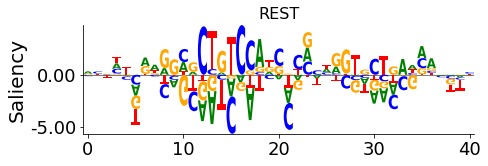

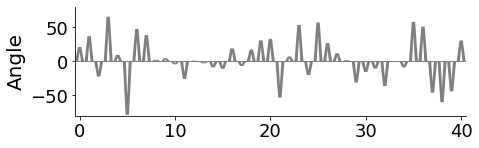

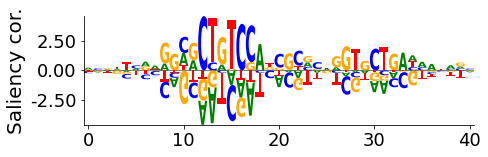

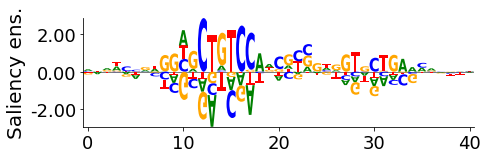

In [ ]:
saliency_map_raw
saliency_map_raw_CORRECTED = np.array(saliency_map_raw) - 0.25 * np.sum(saliency_map_raw, axis=2, keepdims=True) 

s=28 #Pick a sequence s
run_=9  #Choose run

X_50=[]
for i in range (0,len(saliency_map_raw_cummulative)):
    X_50.append(X)   
X_50=np.array(X_50)  

sine_dimensionsadapted=np.expand_dims(sine,3)[run_] 
sine_dimensionsadapted2=np.expand_dims(sine,3)[run_]

from matplotlib.ticker import FormatStrFormatter

import logomaker 


#CUT
b1=77  #0
b2=118  #41
sine_dimensionsadapted_CUT=sine_dimensionsadapted[:,b1:b2]
sine_dimensionsadapted2_CUT=sine_dimensionsadapted2[:,b1:b2]
#X_model_CUT=X_model[:,b1:b2]
saliency_map_raw_CUT= attr_score1_take[:,b1:b2] 
saliency_map_raw_CORRECTED_CUT= attr_score2_take[:,b1:b2] 
saliency_map_raw_AVERAGE_CUT = saliency_map_raw_AVERAGE[:,b1:b2]


# PLOT default saliency
N, L, A = saliency_map_raw_CUT.shape
for i in range(s,s+1):   
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = saliency_map_raw_CUT[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    plt.xticks([0,10,20,30,40])
    #plt.ylim((-0.7,0.7))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.figure.set_size_inches(7, 2)
    ax.set_ylabel('Saliency', fontsize=20)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)
    fig = plt.gcf()
plt.title("REST", fontsize=16, loc='center', pad=None)

# PLOT angle
N, L, A = sine_dimensionsadapted_CUT.shape
for i in range(s,s+1):   
    counts_df = pd.DataFrame(data=0.0, columns=list('∧'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = (sine_dimensionsadapted_CUT)[i][l,a] 

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    plt.xticks([0,10,20,30,40])
    plt.ylim((-80,80)) 
    ax.figure.set_size_inches(7, 2)
    ax.set_ylabel('Angle', fontsize=20)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)    
    fig = plt.gcf()


# plot corrected
N, L, A = saliency_map_raw_CUT.shape
for i in range(s,s+1):   
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = saliency_map_raw_CORRECTED_CUT[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    plt.xticks([0,10,20,30,40])
    #plt.ylim((-0.7,0.7)) 
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.figure.set_size_inches(7, 2)
    ax.set_ylabel('Saliency cor.', fontsize=20)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)    
    fig = plt.gcf()


# plot corrected
N, L, A = saliency_map_raw_CUT.shape
for i in range(s,s+1):   
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = saliency_map_raw_AVERAGE_CUT[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    plt.xticks([0,10,20,30,40])
    #plt.ylim((-0.7,0.7)) 
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.figure.set_size_inches(7, 2)
    ax.set_ylabel('Saliency ens.', fontsize=20)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)    
    fig = plt.gcf()    